# Neural Networks using Transfer Learning with Caffe

**Why Caffe?**
<ul>
  <li>C++ Core</li>
  <li>Can train on multiple GPUs</li>
  <li>Mature code</li>
  <li>Big model zoo</li>
  <li>Pycaffe</li>
</ul>

Caffe installation: http://caffe.berkeleyvision.org/installation.html

Caffe model zoo: http://caffe.berkeleyvision.org/installation.html

**Goal:** classify cells in human brain tissue fluorescence microscopy

<img src="images/fluorescence2.png" width="800">

**Problems**
<ul>
  <li>Small dataset</li>
  <li>Lots of image artifacts</li>
</ul>

**Solution:** Use transfer learning

## So, we'll create our own CellNet by modifying retraining the good old AlexNet!

**AlexNet**
<ul>
  <li>1000 output classes</li>
  <li>Convolutional neural network (ConvNet)</li>
  <li>Won the 2012 ILSVRC (ImageNet Large-Scale Visual Recognition Challenge)</li>
</ul>

<img src="images/alexnet_marks.png" width="800">

## 1. Initialization

In [1]:
import caffe
from caffe import layers as L
from caffe import params as P
from caffe.proto import caffe_pb2
from pylab import *
import os
import tempfile
import fnmatch
from skimage import io
import numpy as np
%matplotlib inline

# uncomment this if you want to use the GPU
#caffe.set_device(0)
#caffe.set_mode_gpu()

# uncompress model files
!bash uncompress_model.sh 

gunzip: bvlc_reference_caffenet.caffemodel: unknown suffix -- ignored
gunzip: weights.pretrained.caffemodel: unknown suffix -- ignored


In [2]:
# caffe instalation path (change to your local caffe home folder)
pwd_dir = os.getcwd() + '/'
caffe_root = pwd_dir + 'models/bvlc_reference_caffenet/'
# image database path (change to the DB location in your machine)
img_root = pwd_dir + 'data/'

### AlexNet original number of labels

In [3]:
NUM_IMGNET_LABELS = 1000

### CellNet labels

In [4]:
NUM_LABELS = 3
CELL_LABELS = ['Red (CP13)', 'Green (casp-6)', 'Yellow (overlap)']

### Model file from the Caffe Model Zoo

In [5]:
weights = caffe_root + 'bvlc_reference_caffenet.caffemodel' #load pretrained weights

In [6]:
# initialize training params and weights
weight_param = dict(lr_mult=1, decay_mult=1)
bias_param = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]
frozen_param = [dict(lr_mult=0)] * 2

##  2. Network setup

### Convolutional layer

<img src="images/conv_layer.jpg" width="300">

In [7]:
def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1,
              param=learned_param,
              weight_filler=dict(type='gaussian', std=0.01),
              bias_filler=dict(type='constant', value=0.1)):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         param=param, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

### Pooling layer

<img src="images/pooling.jpg" width="350">

In [ ]:
def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

### Fully connected layer

<img src="images/mlp.png" width="250">

In [ ]:
def fc_relu(bottom, nout, param=learned_param, 
            weight_filler=dict(type='gaussian', std=0.005), 
            bias_filler=dict(type='constant', value=0.1)):
    fc = L.InnerProduct(bottom, num_output=nout, param=param,weight_filler=weight_filler,bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

## AlexNet Network Architecture

<img src="images/alexnet_diagram_python.png" width="1300">

### caffenet() builds the basic network   

In [8]:
def caffenet(data, label=None, train=True, num_classes=1000, retrain_layers=False, learn_all=False, tmp_file=True):
    n = caffe.NetSpec()
    n.data = data
    param = learned_param if learn_all else frozen_param
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4, param=param)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2, param=param)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1, param=param)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2, param=param)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2, param=param)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096, param=param)
    if train:
        n.drop6 = fc7input = L.Dropout(n.relu6, in_place=True)
    else:
        fc7input = n.relu6

    # fine-tune the network, change layer name, unfreeze learning rate
    if retrain_layers:
        fc7 = L.InnerProduct(fc7input, num_output=4096, param=learned_param,
                             weight_filler=dict(type='gaussian', std=0.005),
                             bias_filler=dict(type='constant', value=0.1))
        n.__setattr__('fc7_new', fc7)
        relu7 = L.ReLU(fc7, in_place=True)
        n.__setattr__('relu7_new',relu7)
    else:
        n.fc7, n.relu7 = fc_relu(fc7input, 4096, param=param)
        relu7 = n.relu7

    if train:
        n.drop7 = fc8input = L.Dropout(relu7, in_place=True)
    else:
        fc8input = relu7

    # fine-tune the network, change layer name, unfreeze learning rate
    fc8 = L.InnerProduct(fc8input, num_output=num_classes, param=learned_param)
    if num_classes != NUM_IMGNET_LABELS:
        n.__setattr__('fc8_new', fc8)
    else:
        n.__setattr__('fc8', fc8)
    if not train:
        n.probs = L.Softmax(fc8)
    if label is not None:
        n.label = label
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)

    # write the net to a temporary file and return its filename
    if tmp_file:
        with tempfile.NamedTemporaryFile(delete=False) as f:
            f.write(str(n.to_proto()))
            return f.name
    else:
        net_name = img_root + 'cell_net.prototxt'
        with open(net_name,'w') as f:
            f.write(str(n.to_proto()))
            return net_name

### dummy_caffenet() uses caffenet() to build an empty AlexNet with 1000 output classes

In [9]:
def dummy_caffenet(train=False, nshape=[1, 3, 227, 227]):
    dummy_data = L.DummyData(shape=dict(dim=nshape))
    net_filename = caffenet(data=dummy_data, train=train)
    return net_filename

### cell_net() uses caffenet() to build an empty network but changes the number of output classes

In [10]:
def cell_net(train=True, learn_all=False, retrain_layers=False, subset=None):
    if subset is None:
        subset = 'train' if train else 'test'
    source = img_root + '%s.txt' % subset # .txt with training/test file lists
    transform_param = dict(mirror=train, crop_size=227, mean_file=img_root + 'mean_image.binaryproto') #mean image
    style_data, style_label = L.ImageData(
        transform_param=transform_param, source=source,
        batch_size=50, new_height=256, new_width=256, ntop=2)
    return caffenet(data=style_data, label=style_label, train=train,
                    num_classes=NUM_LABELS, #### NEW NUMBER OF LABELS ####
                    retrain_layers=retrain_layers,
                    learn_all=learn_all)

## 3. Some basic stuff: Load and classify an image

### A common pre-processing step in ConvNets is substracting the mean from all image pixels

In [11]:
# load the mean image and compute mean values
def load_mean_values(bp_file):
    blob = caffe_pb2.BlobProto()
    data = open(bp_file, 'rb').read()
    blob.ParseFromString(data)
    raw_data = caffe.io.blobproto_to_array(blob)
    arr = np.array(raw_data)
    out = arr[0]
    mu = out.mean(1).mean(1) #mean values, in BGR order
    return mu

### Caffe saves images in BGR, usually with the mean substracted

In [12]:
# prepare image to be displayed
def deprocess_image(image,mu):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [mu[2],mu[1],mu[0]]
    image[image < 0], image[image > 255] = 0, 255
    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)
    return image

## 3.1 Load images from disk and classify it using the original AlexNet

In [13]:
# load ImageNet labels to imagenet_labels
imagenet_label_file = caffe_root + 'synset_words.txt'
imagenet_labels = list(np.loadtxt(imagenet_label_file, str, delimiter='\t'))

### Instantiate an empty AlexNet and initialize it with the downloaded model

In [14]:
# create network
imagenet_net_name = dummy_caffenet() #imagenet has 1000 classes
imagenet_net = caffe.Net(imagenet_net_name,weights,caffe.TEST)

In [15]:
# load our mean image file and compute the mean values
mu = load_mean_values(img_root + 'mean_image.binaryproto')

### Transformer handles the pre-processing, including rescale, mean substraction and channel swap

In [16]:
# create transformer
transformer = caffe.io.Transformer({'data': imagenet_net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel (mu is BGR)
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

### Load image from disk

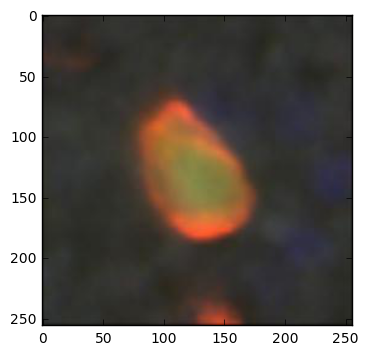

In [17]:
# load some image from the HD
orig_image = caffe.io.load_image(img_root + '6931.12_72_drn-f_0023_class2.jpg')
plt.imshow(orig_image)

In [18]:
# transform image
transf_image = transformer.preprocess('data',orig_image)
imagenet_net.blobs['data'].data[0,...] = transf_image

### Use AlexNet to classify our image

In [19]:
# run forward pass
probs = imagenet_net.forward(start='conv1')['probs'][0]
top_k = (-probs).argsort()[:5] #top 5 predicted classes
print 'top 5 predicted ImageNet labels:'
print '\n'.join('\t(%d) %5.2f%% %s' % (i + 1, 100 * probs[p], imagenet_labels[p])
                for i, p in enumerate(top_k))

top 5 predicted ImageNet labels:
	(1) 42.45% n01443537 goldfish, Carassius auratus
	(2) 30.92% n09472597 volcano
	(3)  9.84% n03590841 jack-o'-lantern
	(4)  2.02% n01910747 jellyfish
	(5)  1.76% n06874185 traffic light, traffic signal, stoplight


## 4. Create Solvers

In [20]:
# declare solver
def solver(train_net_path, test_net_path=None, base_lr=0.001, tmp_file = True):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 1000  # Test after every 1000 training iterations.
        s.test_iter.append(100) # Test on 100 batches each time we test.

    s.iter_size = 1
    s.max_iter = 100000     # # of times to update the net (training iterations)
    s.type = 'SGD'
    s.base_lr = base_lr
    s.lr_policy = 'step'
    s.gamma = 0.1
    s.stepsize = 20000
    s.momentum = 0.9
    s.weight_decay = 5e-4
    s.display = 1000
    s.snapshot = 10000
    s.snapshot_prefix = img_root + 'fine_tune_2layers'

    #s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    # Write the solver to a temporary file and return its filename.
    if tmp_file:
        with tempfile.NamedTemporaryFile(delete=False) as f:
            f.write(str(s))
            return f.name
    else:
        solver_file = img_root + 'cell_net.solver'
        with open(solver_file,'w') as f:
            f.write(str(s))
            return solver_file
       

In [21]:
def run_solvers(niter, solvers, disp_interval=10):
    """Run solvers for niter iterations,
       returning the loss and accuracy recorded each iteration.
       `solvers` is a list of (name, solver) tuples."""
    blobs = ('loss', 'acc')
    loss, acc = ({name: np.zeros(niter) for name, _ in solvers}
                 for _ in blobs)
    for it in range(niter):
        for name, s in solvers:
            s.step(1)  # run a single SGD step in Caffe
            loss[name][it], acc[name][it] = (s.net.blobs[b].data.copy()
                                             for b in blobs)
        if it % disp_interval == 0 or it + 1 == niter:
            loss_disp = '; '.join('%s: loss=%.3f, acc=%2d%%' %
                                  (n, loss[n][it], np.round(100*acc[n][it]))
                                  for n, _ in solvers)
            print '%3d) %s' % (it, loss_disp)     
    # Save the learned weights from both nets.
    weight_dir = tempfile.mkdtemp()
    weights = {}
    for name, s in solvers:
        filename = 'weights.%s.caffemodel' % name
        weights[name] = os.path.join(weight_dir, filename)
        s.net.save(weights[name])
    return loss, acc, weights

## 5. Train the Network (warning: very slow without GPU!)

In [22]:
#niter = 10  # number of iterations to train

# reset style_solver as before.
#cell_solver_filename = solver(cell_net(train=True, retrain_layers=True))
#cell_solver = caffe.get_solver(cell_solver_filename)
#cell_solver.net.copy_from(weights)

#print 'Running solvers for %d iterations...' % niter
#solvers = [('pretrained', cell_solver)]
#loss, acc, weights = run_solvers(niter, solvers)
#print 'Done.'

## 6. Test the Network

In [23]:
def eval_net(weights, test_iters=10):
    test_net = caffe.Net(cell_net(train=False, retrain_layers=True), weights, caffe.TEST)
    accuracy = 0
    for it in xrange(test_iters):
        accuracy += test_net.forward()['acc']
    accuracy /= test_iters
    return test_net, accuracy

### We'll use a pre-trained CellNet model

In [24]:
#use pretrained weights for time sake
cell_weights = pwd_dir + 'models/weights.pretrained.caffemodel'

### Instantiate a new CellNet and initialize it with our pre-trained weights 

In [25]:
# instatiate a new network and initilize it with our just trained weights
cell_net = caffe.Net(cell_net(train=False, subset='train', retrain_layers=True),cell_weights, caffe.TEST)

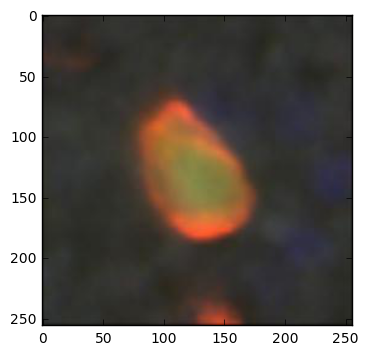

In [26]:
# input image
cell_net.blobs['data'].data[0,...] = transf_image
plt.imshow(orig_image)

### Now classify again our cell image

In [27]:
probs = cell_net.forward(start='conv1')['probs'][0]
top_k = (-probs).argsort()[:3] #top 3 predicted classes
print 'Label predictions:'
print '\n'.join('\t(%d) %5.2f%% %s' % (i + 1, 100 * probs[p], CELL_LABELS[p])
                for i, p in enumerate(top_k))

Label predictions:
	(1) 97.22% Yellow (overlap)
	(2)  2.61% Red (CP13)
	(3)  0.17% Green (casp-6)
